# FuseTS - CropSAR
This Jupyter Notebook implements the CropSAR service, which is part of the FuseTS toolbox. The purpose of this notebook is to demonstrate the usage of openEO to execute the CropSAR service for a specific area of interest (AOI).

The CropSAR service is designed to provide valuable insights into crop monitoring and analysis by augmernting Sentinel-2 observations using that uses Sentinel-1 radar. This process enables the monitoring of agricultural fields regardless of weather conditions or daylight, making it a powerful tool for crop assessment.





## Setting up the OpenEO process
The first step includes setting up the OpenEO processing through the [OpenEO Python Client](https://open-eo.github.io/openeo-python-client/). Since the CropSAR algorithm is integrated as an [user defined process](https://open-eo.github.io/openeo-python-client/cookbook/udp_sharing.html), we can use the `datacube_from_process` function to execute the service.

In [1]:
import openeo
import datetime
import tempfile
import rasterio
import os
import xarray
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
connection = openeo.connect("openeo.vito.be").authenticate_oidc()
service = 'CropSAR_px'
namespace = 'vito'

Authenticated using refresh token.


In [3]:
connection.describe_process(service, namespace=namespace)

{'description': '# CropSAR_px\n\n## Description\n\nThe `CropSAR_px` process generates cloud-free Sentinel-2 data in 5-day intervals. Currently, the following outputs are\nsupported:\n\n- NDVI\n- FAPAR\n- FCOVER\n- RGB_NIR\n\n## Usage\n\nThis code example highlights the usage of the CropSAR_px process in an OpenEO batch job.\nThe result of this batch job will consist of individual GeoTIFF files per date.\nGenerating multiple GeoTIFF files as output is only possible in a batch job.\n\nBy default, the output variable will be NDVI. You can get another output by providing one of the supported values (see\nabove) to the `output` parameter.\n\n```python\nimport openeo\n\n# define ROI and TOI\ngeometry = {\n    "type": "Polygon",\n    "coordinates": [\n        [\n            [\n                5.034656524658203,\n                51.20946446493662\n            ],\n            [\n                5.080232620239258,\n                51.20946446493662\n            ],\n            [\n                5.080232620239258,\n                51.234084900561015\n            ],\n            [\n                5.034656524658203,\n                51.234084900561015\n            ],\n            [\n                5.034656524658203,\n                51.20946446493662\n            ]\n        ]\n    ]\n}\n\nstartdate = "2020-05-01"\nenddate = "2020-06-01"\n\n# get datacube\nconnection = openeo.connect("https://openeo.vito.be")\ncube = connection.datacube_from_process(\n    "CropSAR_px",\n    namespace="vito",\n    geometry=geometry,\n    startdate=startdate,\n    enddate=enddate,\n    version=2,\n    output="NDVI"\n)\njob = cube.execute_batch(\n    title="CropSAR_px",\n    out_format="GTIFF",\n    job_options={\n        "executor-cores": "8",\n        "task-cpus": "8",\n        "executor-memoryOverhead": "2g"\n    }\n)\nresults = job.get_results()\nresults.download_files("out")  # write files to output directory\n```\n\n### Scaling\n\nDepending on the selected output variable, an appropriate data type and scaling will be used. The following table\nprovides an overview of the different scalings for each output variable.\n\n| Output  | Data type | Scaling factor | Offset |\n|---------|-----------|----------------|--------|\n| NDVI    | byte      | 0.004          | -0.08  | \n| FAPAR   | byte      | 0.005          | 0      |\n| FCOVER  | byte      | 0.005          | 0      |\n| RGB_NIR | int16     | 0.0001         | 0      |\n\nIf you want to convert back to the physical values, you have to use the following\ncalculation: `x * scaling_factor + offset`\n\n### Mask output\n\nThe `output_mask` parameter can be used to include a mask per date in the output based on the Sentinel-2 input data.\nThe following table gives an overview of the meaning of the mask values:\n\n| Value | Meaning                                  |\n|-------|------------------------------------------|\n| 0     | no data                                  |\n| 1     | data                                     |\n| 2     | manually masked                          |\n| 3     | no prediction because all NaN input data |\n\n## Limitations\n\nThe spatial extent is limited to a maximum size equal to a Sentinel-2 MGRS tile (100 km x 100 km).\nThe temporal extent is limited to 1 year.\n\nFor large spatial areas or temporal intervals, it is recommended to split the job in multiple smaller tasks.\n\n## Configuration & Resource Usage\n\nHere is an overview of run configurations for different ROI/TOI with memory requirements and estimated run durations.\n\n### Batch jobs\n\n| Spatial extent | Temporal extent | Executor memory | Run duration (sec) | Cost (credits) |\n|----------------|-----------------|-----------------|--------------------|----------------|\n| 100 m x 100 m  | 1 month         | default         | 171                | 22             |\n| 500 m x 100 m  | 1 month         | default         | 220                | 29             |\n| 1 km x 1 km    | 1 month         | default         | 220       

### Use `datacube_from_process` to get initial DataCube
Get output datacube from process by passing in the process parameters:
**Mandatory**
- `geometry`: GeoJSON feature
- `startdate`: start of temporal interval
- `enddate`: end of temporal interval
- `output`: Variable to calculate

**Optional**
- `nrt`: only use prior information (default: false)
- `inpaint_only`: only predict areas with no ground truth data (default: true)
- `output_mask`: output ground truth mask (deafult: false)
- `drop_dates`: list of dates

In [4]:
geometry = {
    "type": "Polygon",
    "coordinates": [
        [
            [
                5.034656524658203,
                51.20946446493662
            ],
            [
                5.080232620239258,
                51.20946446493662
            ],
            [
                5.080232620239258,
                51.234084900561015
            ],
            [
                5.034656524658203,
                51.234084900561015
            ],
            [
                5.034656524658203,
                51.20946446493662
            ]
        ]
    ]
}

dates = ['2021-07-01', '2021-07-31']
date_format = "%Y-%m-%d"

datacube = connection.datacube_from_process(
    service, namespace=namespace,
    geometry=geometry,
    startdate=dates[0],
    enddate=dates[1],
    drop_dates=[date.strftime(date_format) for date in [datetime.date(2021, 7, x) for x in range(3, 12)]],
    version=2,
    output_mask=True,
    output="NDVI"
)

/Users/bramjanssen/projects/vito/FuseTS/venv_clean_v2/lib/python3.8/site-packages/openeo/metadata.py:264: UserWarning: No cube:dimensions metadata
  complain("No cube:dimensions metadata")


### Execute job and download result

In [5]:
job = datacube.execute_batch(
    title="FuseTS - CropSAR",
    out_format="GTIFF",
    job_options={
        "executor-cores": "8",
        "task-cpus": "8",
        "executor-memoryOverhead": "2g",
    }
)

0:00:00 Job 'j-8a7c1f3836f441d994ced509e194f5b5': send 'start'
0:00:23 Job 'j-8a7c1f3836f441d994ced509e194f5b5': queued (progress N/A)
0:00:28 Job 'j-8a7c1f3836f441d994ced509e194f5b5': queued (progress N/A)
0:00:35 Job 'j-8a7c1f3836f441d994ced509e194f5b5': queued (progress N/A)
0:00:49 Job 'j-8a7c1f3836f441d994ced509e194f5b5': queued (progress N/A)
0:00:59 Job 'j-8a7c1f3836f441d994ced509e194f5b5': queued (progress N/A)
0:01:12 Job 'j-8a7c1f3836f441d994ced509e194f5b5': queued (progress N/A)
0:01:28 Job 'j-8a7c1f3836f441d994ced509e194f5b5': queued (progress N/A)
0:01:48 Job 'j-8a7c1f3836f441d994ced509e194f5b5': running (progress N/A)
0:02:12 Job 'j-8a7c1f3836f441d994ced509e194f5b5': running (progress N/A)
0:02:42 Job 'j-8a7c1f3836f441d994ced509e194f5b5': running (progress N/A)
0:03:20 Job 'j-8a7c1f3836f441d994ced509e194f5b5': running (progress N/A)
0:04:07 Job 'j-8a7c1f3836f441d994ced509e194f5b5': running (progress N/A)
0:05:06 Job 'j-8a7c1f3836f441d994ced509e194f5b5': running (progress 

In [6]:
results = job.get_results()
output_directory = tempfile.TemporaryDirectory()
files = results.download_files(output_directory.name)
files = [file for file in files if os.path.splitext(file)[1] == ".tif"]

## Explore results
The first band of the output will be the CropSAR_px NDVI prediction.
The second band contains the Sentinel-2 input mask (if requested via `output_mask`). The values of this mask have the following meaning:
 - 0: no data (clouds, ...)
 - 1: ground truth data
 - 2: manually masked (via `drop_dates` parameter)

### Scaling
The output contains NDVI values in the interval [-0.08; 1] scaled to the byte output range [0; 250].
If you want to convert back to the physical values, you have to use the following scaling factor: `x * 0.00432 - 0.08`


/var/folders/50/09_2zmx12zj6ks4fdl4y9wgc0000gn/T/ipykernel_23789/3843306284.py:6: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  ds = xarray.open_rasterio(file)
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
/var/folders/50/09_2zmx12zj6ks4fdl4y9wgc0000gn/T/ipykernel_23789/3843306284.py:6: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  ds = xarray.open_rasterio(file)
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
/var/folders/50/09_2zmx12zj6ks4fdl4y9wgc0000

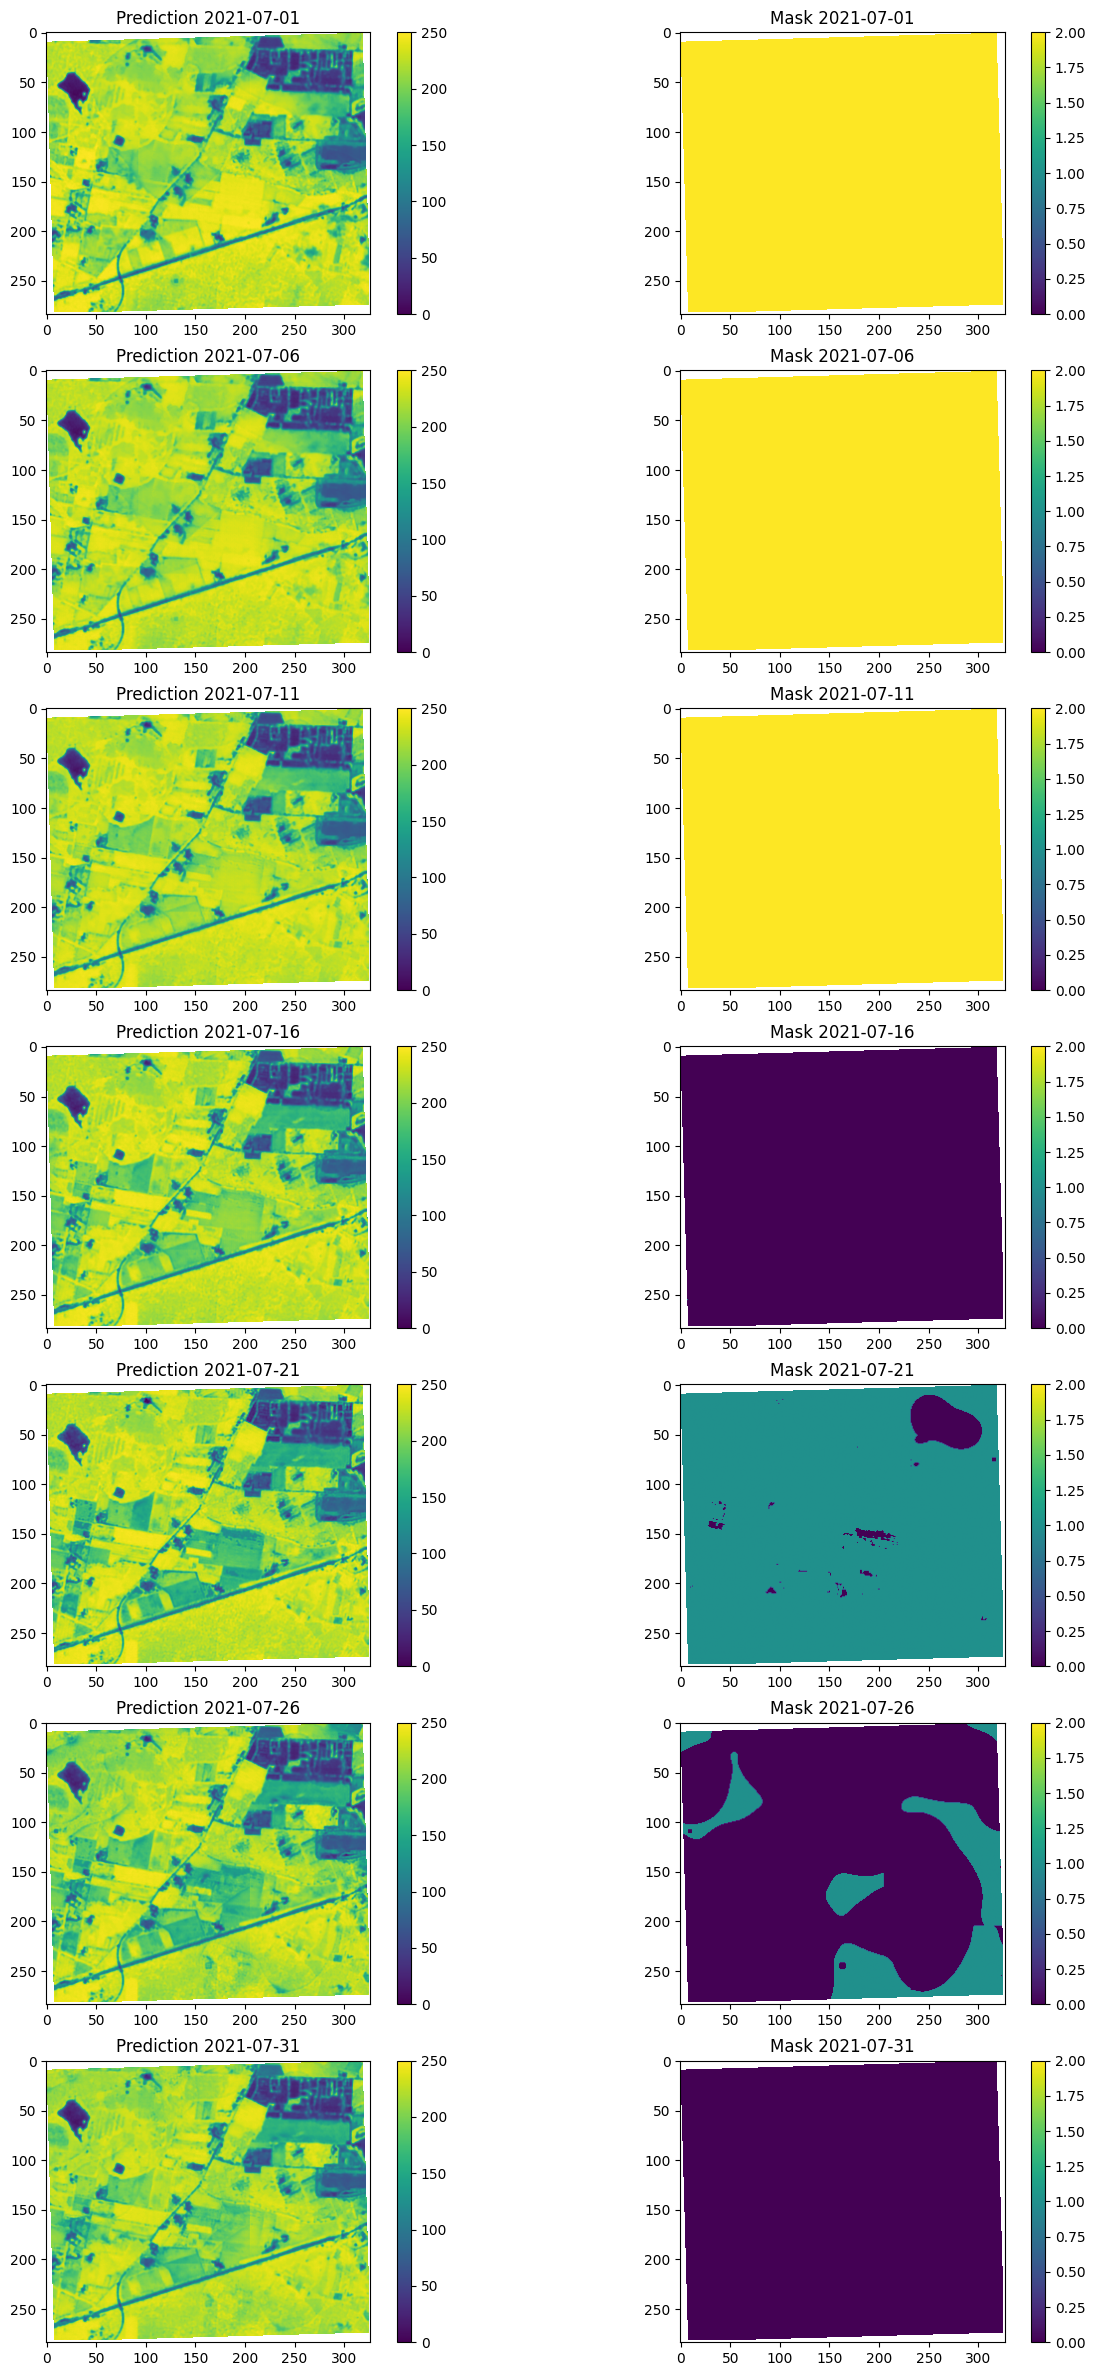

In [7]:
nrows = len(files)
ncols = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(15, 30))

for i, file in enumerate(files):
    ds = xarray.open_rasterio(file)
    ds = ds.where(ds != 255)  # filter no data value
    
    date = os.path.splitext(os.path.basename(file))[0].split('_')[-1][:-1]
    
    im_pred = axs[i, 0].imshow(ds[0], vmin=0, vmax=250)
    axs[i, 0].set_title(f"Prediction {date}")
    fig.colorbar(im_pred, ax=axs[i, 0])
    
    im_mask = axs[i, 1].imshow(ds[1], vmin=0, vmax=2)
    axs[i, 1].set_title(f"Mask {date}")
    fig.colorbar(im_mask, ax=axs[i, 1])


## Cleanup
Cleanup of the temporary directory

In [8]:
output_directory.cleanup()